In [1]:

import numpy as np
import pandas as pd

import os, sys
BASE_DIR = os.path.abspath("Usage & examples")  # 현재 디렉토리 기준으로 상위 폴더
sys.path.append(BASE_DIR)
from PFM_v1 import PFM_simple
from PFM_v2 import PFM
from simulator import MembraneProc

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler

COLOR_CODE = ["#2364aa", "#3da5d9", "#73bfb8", "#fec601", "#ea7317"]
import matplotlib.cm as cm
def set_common_style():
        
    mpl.rcParams.update({
        # [폰트 관련]
        'font.family': 'Arial',             # 글꼴 종류
        'font.size': 17,                    # 기본 폰트 크기

        # [축 관련]
        'axes.grid': True,                  # 기본 그리드 표시 여부
        'grid.linestyle': '--',             # 그리드 스타일
        'grid.alpha': 0.5,                  # 그리드 투명도

        # [눈금 설정]
        'xtick.direction': 'in',            # 눈금 안쪽으로
        'ytick.direction': 'in',

        # [범례]
        'legend.frameon': False,            # 범례 박스 제거
        'legend.loc': 'best',               # 범례 위치 자동
        'legend.edgecolor': 'none',         # 범례 테두리 색

        # [Figure 설정]
        'figure.figsize': (6, 4),           # 기본 figure 크기 (inches)
        'figure.dpi': 300,                  # 디스플레이 해상도
        'savefig.dpi': 300,                 # 저장 해상도
        'savefig.transparent': True,        # 저장 시 투명 배경
        'savefig.bbox': 'tight',            # 저장 시 여백 최소화

        # [PDF/PS 설정]
        'pdf.fonttype': 42,                 # 벡터화 폰트 유지
        'ps.fonttype': 42,
        
        "axes.prop_cycle": cycler('color', COLOR_CODE)
    })
set_common_style()

from matplotlib import colors

def make_white_gradient(base_color, n=5):
    base_rgb = np.array(colors.to_rgb(base_color))
    white_rgb = np.array([1, 1, 1])  # RGB for white
    # 밝은 색부터 진한 색까지 (white → base_color)
    gradient = [colors.to_hex(white_rgb * (1 - t) + base_rgb * t) for t in np.linspace(0, 1, n)]
    return gradient

# Simplied model

In [104]:
def PFM_simple_stg(F_feed):
    # original case
    D_inner = 200*1e-3            # Membrane inner diameter (mm)
    D_outer = 250*1e-3            # Membrane outer diameter (mm)
    thickness = (D_outer-D_inner)/2
    D_module = 0.1*1e3            # Module diameter (mm)
    N_fiber = 60000               # number of fiber (-)
    L = 0.6*1e3                   # fiber length (mm)

    D_avg = (D_inner+D_outer)/2
    A_mem = np.pi*D_outer*L*N_fiber

    # Operating conditions
    P_feed = 35                # pressure of feed side (bar)
    T = 308
    # F_feed = 0.35
    y_feed = np.array([0.1, 0.9])     # mole fraction (CO2, CH4)
    Ff_z0_init = list(y_feed*F_feed)

    L_channel = 0.6*1e3                     # Channel length (mm)
    w_channel = 0.1*1e3                     # Channel width (mm)
    h_channel = 250*1e-3                    # Channel height (mm)
    N_channel = int(A_mem/(L*w_channel))/2    # number of channels (-)

    # Gas properties
    Mw_i = np.array([44e-3, 16e-3])     # Molar weight (kg/mol)
    rho_i = np.array([1.98, 0.657])*1e-9     # Density (kg/mm3)
    mu_H2 = 0.0155e-3           # CO2 viscosity (Pa s)
    mu_N2 = 0.011e-3           # CH4 viscosity (Pa s)
    # viscosity values from https://www.engineeringtoolbox.com/gases-absolute-dynamic-viscosity-d_1888.html
    mu_i = np.array([mu_H2, mu_N2])

    k_mass = 1e-1               # Mass transfer coeff. (mm/s)

    N = 400
    a_perm = np.array([3.207e-9, 1.33e-10])*1e-6*1e5     #Permeance(mol/(mm2 bar s))

    mem_model = PFM_simple(config = 'co',
                    channel_num=N_channel,
                    channel_size=[L_channel, w_channel, h_channel],       #mm
                    n_component=2,
                    n_node=N)

    mem_model.membrane_info(thickness=thickness,              # mm
                            a_perm=a_perm)
    mem_model.gas_prop_info(molar_mass = Mw_i,
                            mu_viscosity = mu_i, 
                            rho_density = rho_i)
    mem_model.mass_trans_info(k_mass_transfer = k_mass)
    mem_model.boundaryC_info(y_inlet = y_feed,
                                p_f_inlet = P_feed,
                                f_f_inlet = F_feed,
                                T_inlet = T,
                                f_sweep = False)
    mem_model.initialC_info()
    pfm_res = mem_model.run_mem(tolerance=1e-7, 
                        iteration=20000, 
                        Kg=0.01, 
                        cp=False, 
                        cp_cond = False)

    return mem_model, pfm_res

# Boram Gu:

In [105]:
def HFM_stg(F_feed):
    # Operating conditions
    P_feed = 35                # pressure of feed side (bar)
    T = 308
    # F_feed = 0.35
    y_feed = np.array([0.1, 0.9])     # mole fraction (CO2, CH4)
    Ff_z0_init = list(y_feed*F_feed)

    # Sizing parameters
    D_inner = 200*1e-3            # Membrane inner diameter (mm)
    D_outer = 250*1e-3            # Membrane outer diameter (mm)
    thickness = (D_outer-D_inner)/2
    D_module = 0.1*1e3            # Module diameter (mm)
    N_fiber = 60000               # number of fiber (-)
    L = 0.6*1e3                   # fiber length (mm)
    Ac_shell = np.pi*D_module**2/4 - N_fiber*np.pi*D_inner**2/4     # (mm^2)
    config = 'COFS'

    # Gas properties
    Mw_i = np.array([44e-3, 16e-3])     # Molar weight (kg/mol)
    rho_i = np.array([1.98, 0.657])*1e-9     # Density (kg/mm3)
    mu_H2 = 0.0155e-3           # CO2 viscosity (Pa s)
    mu_N2 = 0.011e-3           # CH4 viscosity (Pa s)
    # viscosity values from https://www.engineeringtoolbox.com/gases-absolute-dynamic-viscosity-d_1888.html
    mu_i = np.array([mu_H2, mu_N2])

    k_mass = 1e-1               # Mass transfer coeff. (mm/s)

    N = 400
    a_perm = np.array([3.207e-9, 1.33e-10])*1e-6*1e5     #Permeance(mol/(mm2 bar s))

    n_component = 2
    mem = MembraneProc(config, L, D_module, N_fiber, 
                n_component, n_node = N)
    mem.membrane_info(a_perm, D_inner, D_outer)
    mem.gas_prop_info(Mw_i, mu_i, rho_i)
    mem.mass_trans_info(k_mass)
    mem.boundaryC_info(y_feed, P_feed, F_feed, T)
    mem.initialC_info()

    #single
    hfm_res = mem.run_mem(cp=False, cp_cond = [1, 298])
    err = mem.MassBalance()
    return mem, hfm_res

Simulation started
Simulation is completed without warning


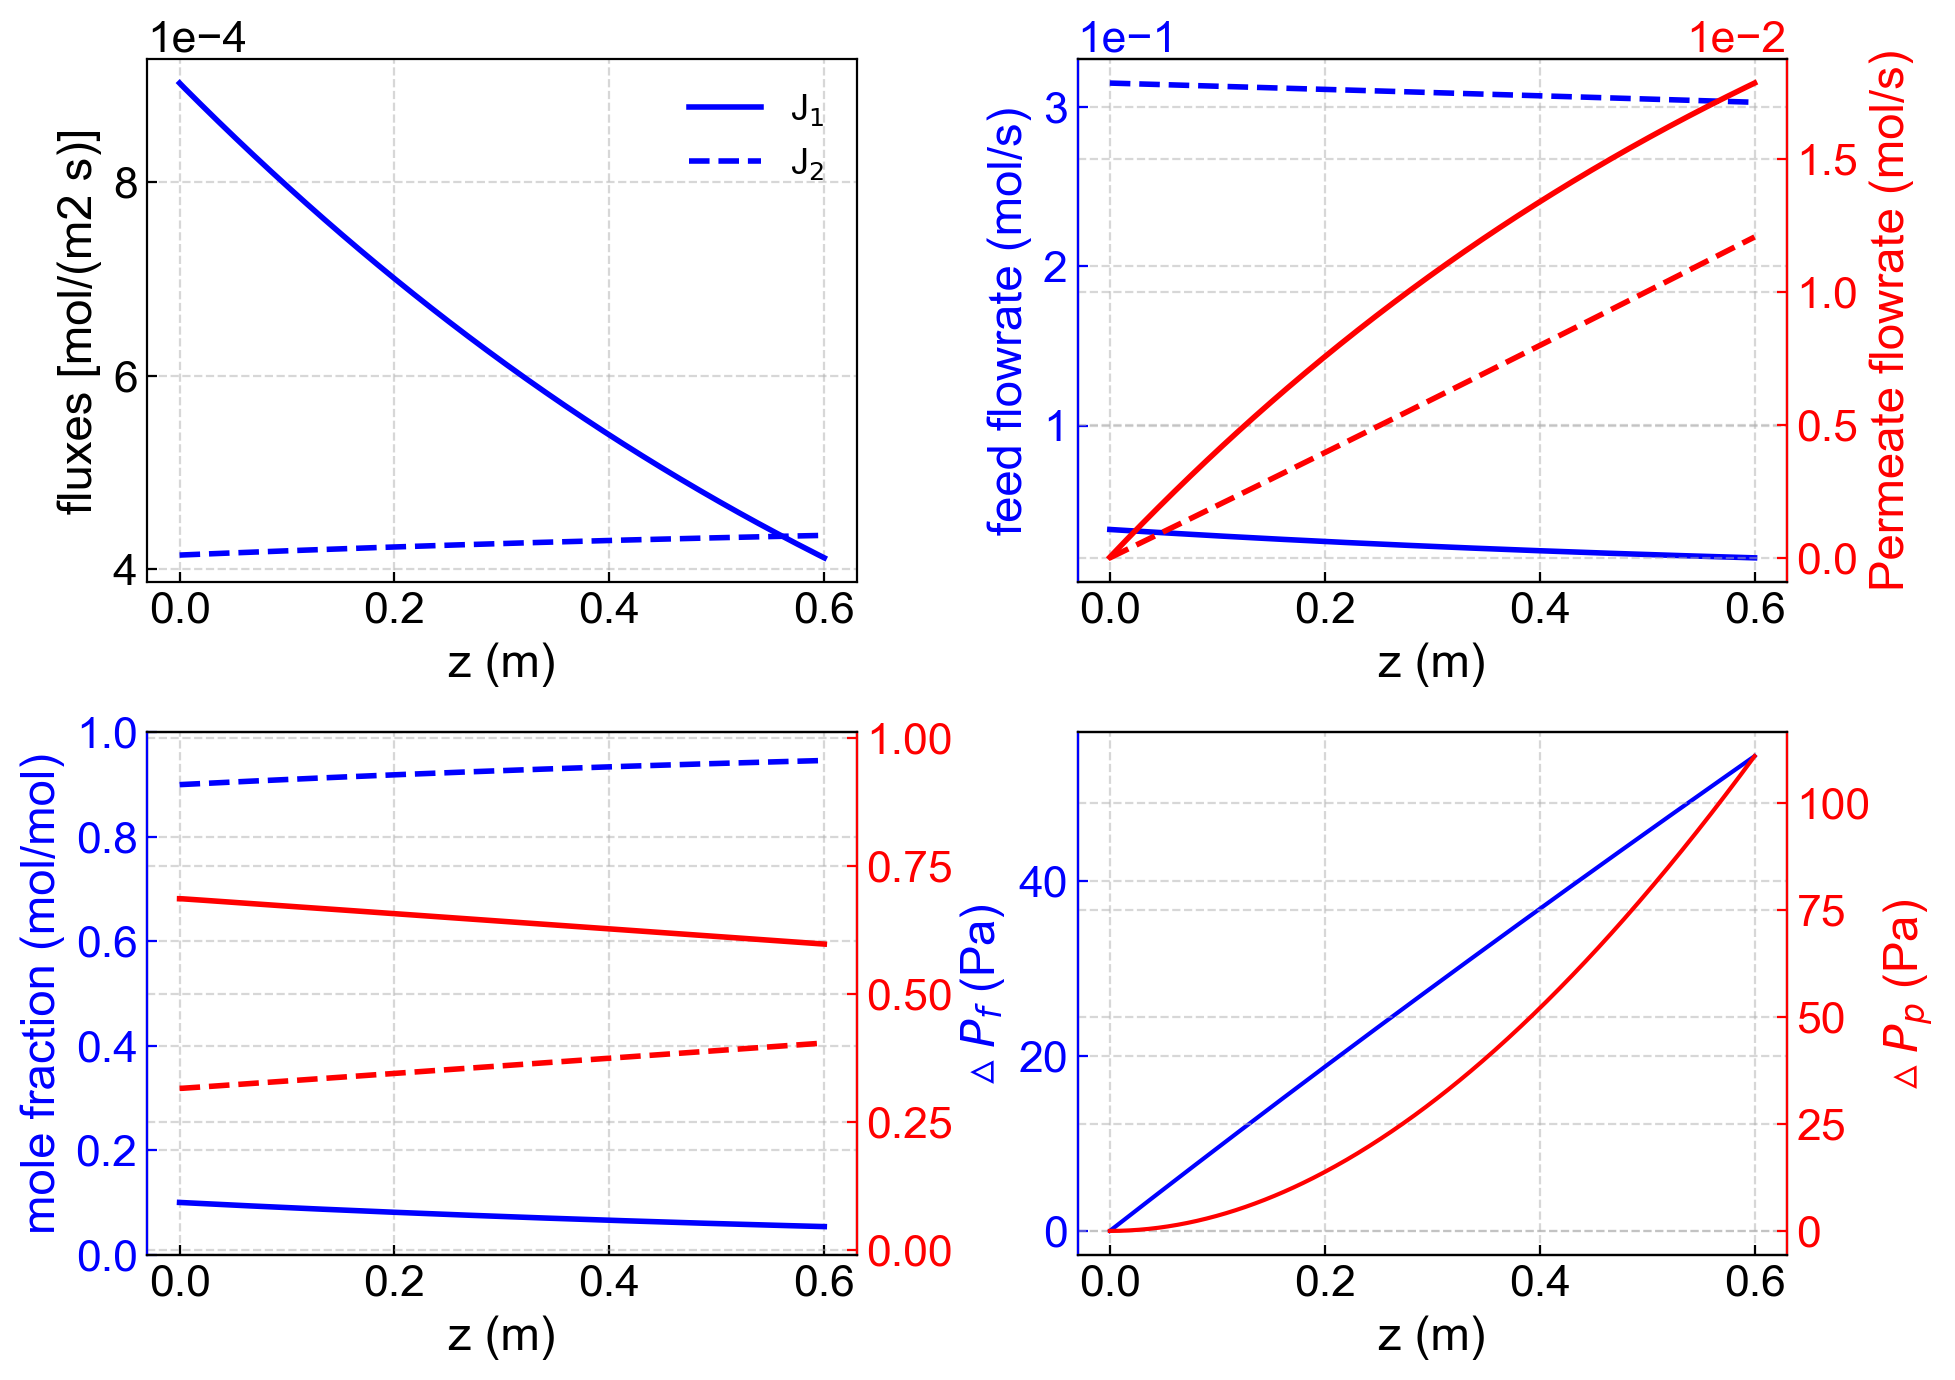

Simulation started
Simulation is completed without warning
Mass balance (error %):  9.513671771296887e-14


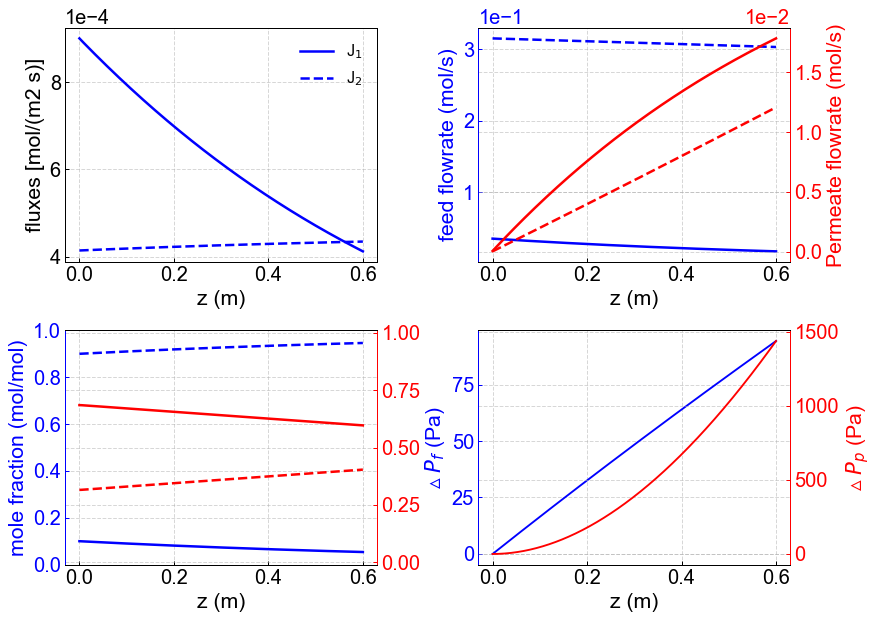

In [106]:
F_feed = 0.35

model_pfm_simp, PFM_simp_res = PFM_simple_stg(F_feed)
model_pfm_simp.PlotResults()

model_hfm_simp, HFM_res = HFM_stg(F_feed)
model_hfm_simp.PlotResults()

In [103]:
def simple_eval(y_res, mode = 'co'):
    
    f_f = np.array([y_res[:,i] for i in range(2)])
    f_p = np.array([y_res[:,i+2] for i in range(2)])
    Pf, Pp = y_res[:,2*2], y_res[:,2*2+1]
    x_i = f_f/np.sum(f_f, axis=0)
    y_i = f_p/np.sum(f_p, axis=0)
    
    if mode == 'co':
        perm_out = sum(f_p[:,-1])
    else:
        perm_out = sum(f_p[:,0])
        
    stage_cut = perm_out/sum(f_f[:,0])
    recovery = sum(f_f[:,-1])/sum(f_f[:,0])
    residue_comp = x_i[0,-1]
    return stage_cut, recovery, residue_comp

In [58]:
pfm_eval = []
hfm_eval = []
for F_feed in np.logspace(np.log10(0.1), np.log10(3), 10):
    model_pfm_simp, PFM_simp_res = PFM_simple_stg(F_feed)
    model_hfm_simp, HFM_res = HFM_stg(F_feed)

    stg_pfm, rec_pfm, xr_pfm = simple_eval(PFM_simp_res, mode = 'co')
    stg_hfm, rec_hfm, xr_hfm = simple_eval(HFM_res, mode = 'co')
    
    pfm_eval.append([stg_pfm, rec_pfm, xr_pfm])
    hfm_eval.append([stg_hfm, rec_hfm, xr_hfm])

Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Mass balance (error %):  9.705428340916013e-14
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Mass balance (error %):  7.603422013351172e-14
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Mass balance (error %):  2.605802917438245e-14
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Mass balance (error %):  0.0
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Mass balance (error %):  6.120162086670491e-14
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Mass balance (error %):  1.0066478916381424e-13
Simulation started
Simulati

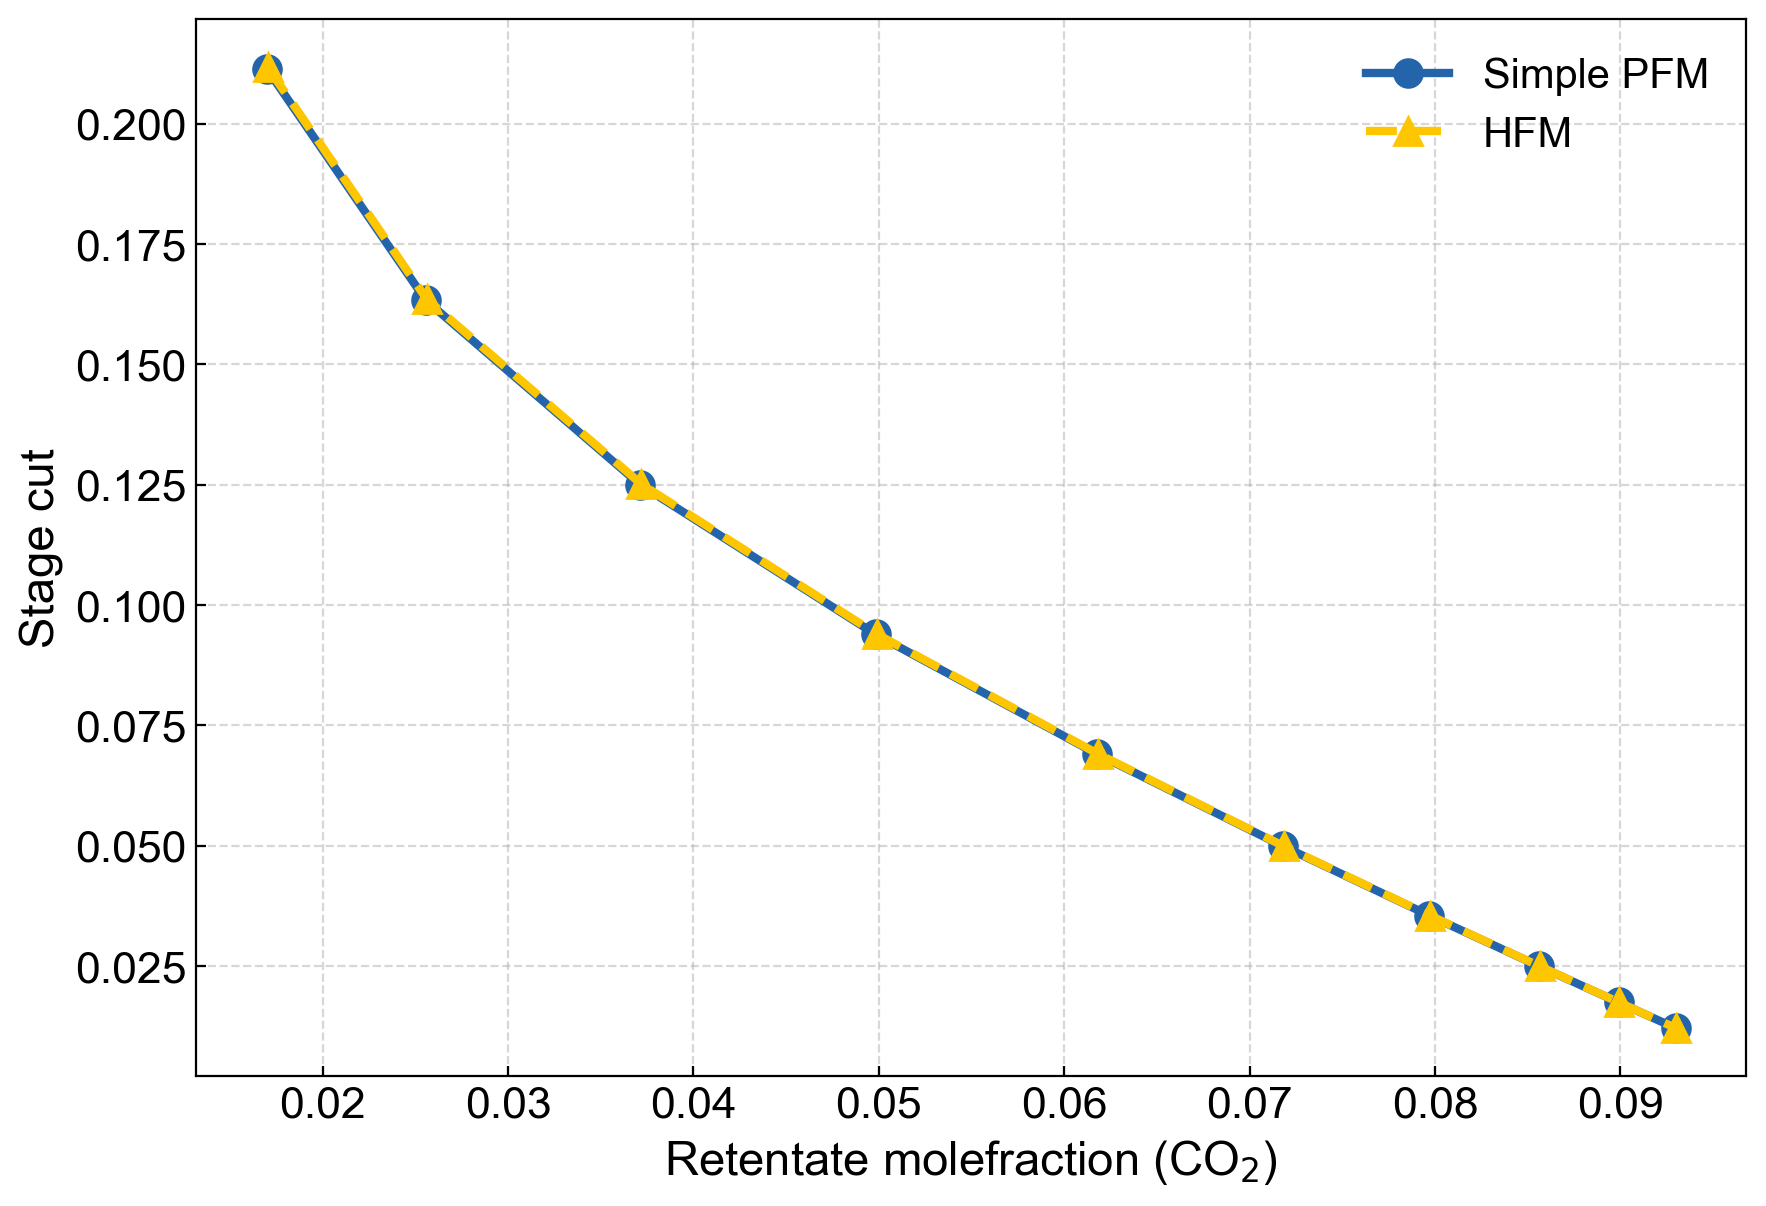

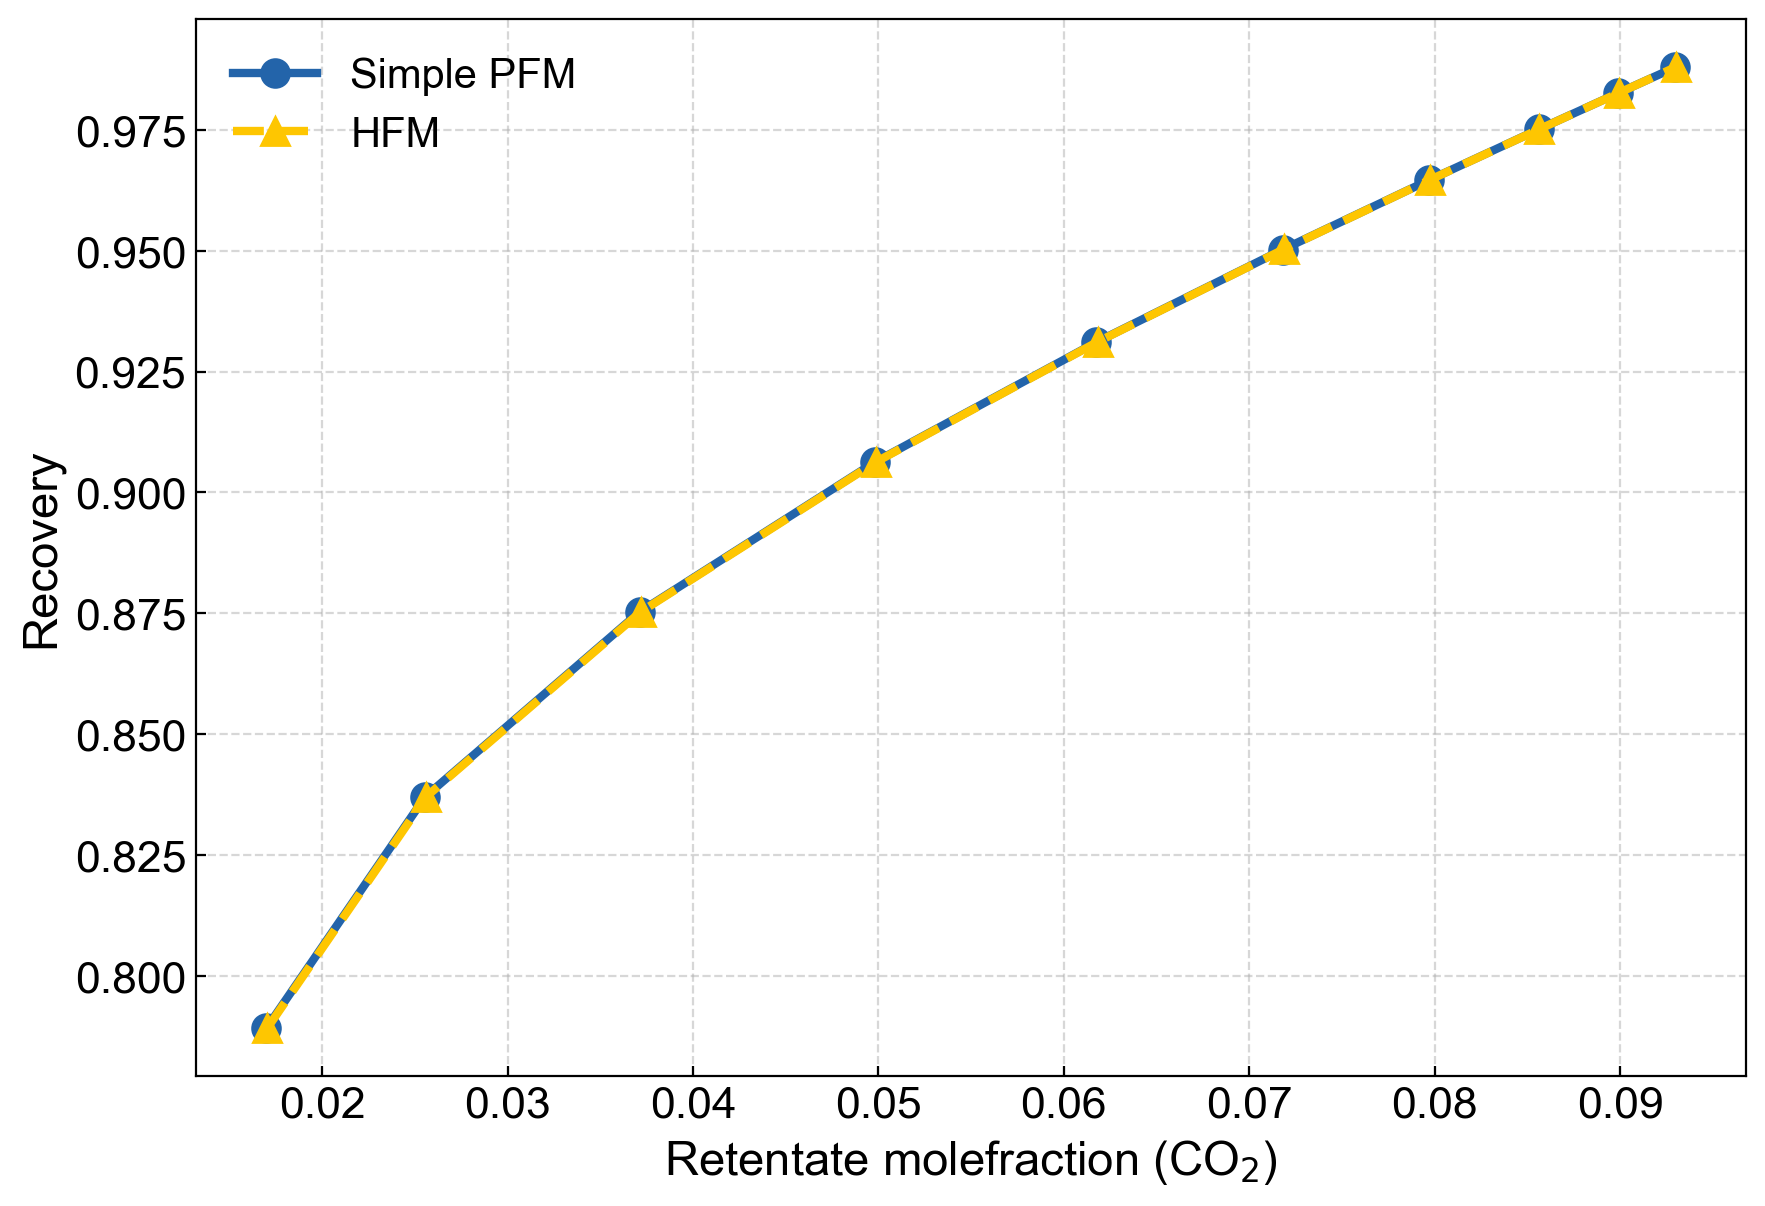

In [59]:
pfm_arr = np.array(pfm_eval)
hfm_arr = np.array(hfm_eval)

plt.figure(figsize=(10,7), dpi=200)
plt.plot(pfm_arr[:,-1], pfm_arr[:,0], label='Simple PFM', alpha=1, marker = 'o',
        #  edgecolors='k', 
        linewidth=3, markersize = 10,
        #  s=150
         )
plt.plot(hfm_arr[:,-1], hfm_arr[:,0], label='HFM', alpha=1,
        #  edgecolors='k', 
        linewidth=3, markersize = 10, linestyle = '--',
        #  s=150,
            c = COLOR_CODE[-2], marker='^')
plt.legend(fontsize=15)
plt.xlabel('Retentate molefraction (CO$_2$)')
plt.ylabel('Stage cut')
plt.show()

plt.figure(figsize=(10,7), dpi=200)
plt.plot(pfm_arr[:,-1], pfm_arr[:,1], label='Simple PFM', alpha=1, marker = 'o',
        #  edgecolors='k', 
        linewidth=3, markersize = 10,
        #  s=150
         )
plt.plot(hfm_arr[:,-1], hfm_arr[:,1], label='HFM', alpha=1,
        #  edgecolors='k', 
        linewidth=3, markersize = 10, linestyle = '--',
        #  s=150,
            c = COLOR_CODE[-2], marker='^')
plt.xlabel('Retentate molefraction (CO$_2$)')
plt.legend(fontsize=15)
plt.ylabel('Recovery')
plt.show()

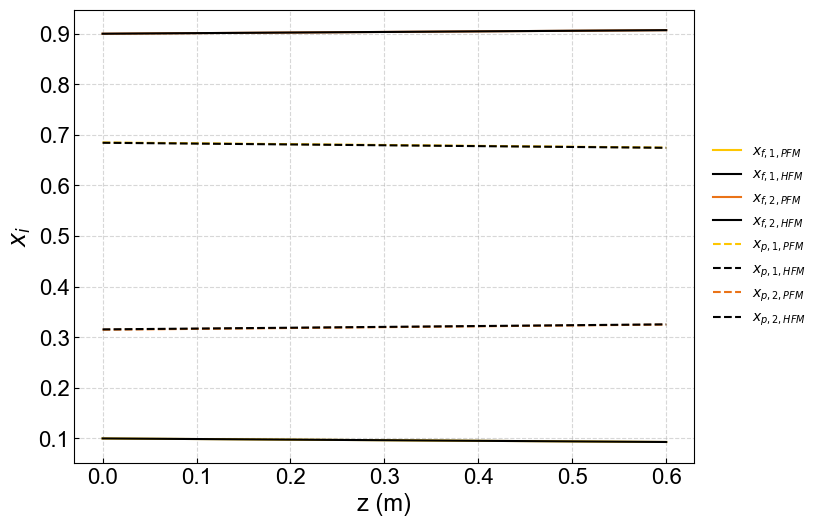

In [22]:
L = 0.6e3
N = 400
var_names = ['F$_{f,1}$ (mol/s)', 'F$_{f,2}$ (mol/s)', 'F$_{p,1}$ (mol/s)', 'F$_{p,2}$ (mol/s)', 'P$_f$ (bar)', 'P$_p$ (bar)']
# purity
plt.figure(figsize=(8,6), dpi=100)
pfm_pu_f = PFM_simp_res[:,0] / (PFM_simp_res[:,0]+PFM_simp_res[:,1])
hfm_pu_f = HFM_res[:,0] / (HFM_res[:,0]+HFM_res[:,1])

pfm_pu_p = PFM_simp_res[:,2] / (PFM_simp_res[:,2]+PFM_simp_res[:,3])
hfm_pu_p = HFM_res[:,2] / (HFM_res[:,2]+HFM_res[:,3])

plt.plot(np.linspace(0, L, N+1)/1e3, pfm_pu_f, label = '$x_{f,1,PFM}$', c=COLOR_CODE[3])
plt.plot(np.linspace(0, L, N+1)/1e3, hfm_pu_f, label = '$x_{f,1,HFM}$',c='k')
plt.plot(np.linspace(0, L, N+1)/1e3, 1-pfm_pu_f, label = '$x_{f,2,PFM}$',c=COLOR_CODE[4])
plt.plot(np.linspace(0, L, N+1)/1e3, 1-hfm_pu_f, label = '$x_{f,2,HFM}$', c='k')

plt.plot(np.linspace(0, L, N+1)/1e3, pfm_pu_p, label = '$x_{p,1,PFM}$', linestyle = '--', c=COLOR_CODE[3])
plt.plot(np.linspace(0, L, N+1)/1e3, hfm_pu_p, label = '$x_{p,1,HFM}$', linestyle = '--', c='k')
plt.plot(np.linspace(0, L, N+1)/1e3, 1-pfm_pu_p, label = '$x_{p,2,PFM}$', linestyle = '--', c=COLOR_CODE[4])
plt.plot(np.linspace(0, L, N+1)/1e3, 1-hfm_pu_p, label = '$x_{p,2,HFM}$', linestyle = '--', c='k')

plt.legend(loc = 'center left', bbox_to_anchor = (1.01,0.5))
plt.xlabel('z (m)')
plt.ylabel('$x_i$')
plt.show()

## stagecut variation

In [13]:
def PFM_model(F_feed):
    # original case
    D_inner = 200*1e-3            # Membrane inner diameter (mm)
    D_outer = 250*1e-3            # Membrane outer diameter (mm)
    thickness = (D_outer-D_inner)/2
    N_fiber = 60000               # number of fiber (-)

    A_mem = np.pi*D_outer*L*N_fiber


    # Operating conditions
    P_feed = 35                # pressure of feed side (bar)
    T = 308
    y_feed = np.array([0.1, 0.9])     # mole fraction (CO2, CH4)

    L_channel = 0.6*1e3                     # Channel length (mm)
    w_channel = 0.1*1e3                     # Channel width (mm)
    h_channel = 250*1e-3                    # Channel height (mm)
    N_channel = int(A_mem/(L*w_channel))/2    # number of channels (-)

    # Gas properties
    Mw_i = np.array([44e-3, 16e-3])     # Molar weight (kg/mol)
    rho_i = np.array([1.98, 0.657])*1e-9     # Density (kg/mm3)
    mu_H2 = 0.0155e-3           # CO2 viscosity (Pa s)
    mu_N2 = 0.011e-3           # CH4 viscosity (Pa s)
    # viscosity values from https://www.engineeringtoolbox.com/gases-absolute-dynamic-viscosity-d_1888.html
    mu_i = np.array([mu_H2, mu_N2])

    k_mass = 1e-1               # Mass transfer coeff. (mm/s)

    N = 400
    a_perm = np.array([3.207e-9, 1.33e-10])*1e-6*1e5     #Permeance(mol/(mm2 bar s))

    mem_model = PFM(config = 'co',
                    channel_num=N_channel,
                    channel_size=[L_channel, w_channel, h_channel],       #mm
                    n_component=2,
                    n_node=N)

    mem_model.membrane_info(thickness=thickness,              # mm
                            a_perm=a_perm)
    mem_model.gas_prop_info(molar_mass = Mw_i,
                            mu_viscosity = mu_i, 
                            rho_density = rho_i)
    mem_model.mass_trans_info(k_mass_transfer = k_mass)
    mem_model.boundaryC_info(y_inlet = y_feed,
                                p_f_inlet = P_feed,
                                f_f_inlet = F_feed,
                                T_inlet = T,
                                f_sweep = False)
    mem_model.initialC_info()
    pfm_res = mem_model.run_mem(tolerance=1e-7, 
                        iteration=20000, 
                        Kg=0.01, 
                        cp=False, 
                        cp_cond = False)
    return mem_model, pfm_res

In [14]:
def HFM_model(F_feed):
    # Operating conditions
    P_feed = 35                # pressure of feed side (bar)
    T = 308
    y_feed = np.array([0.1, 0.9])     # mole fraction (CO2, CH4)

    # Sizing parameters
    D_inner = 200*1e-3            # Membrane inner diameter (mm)
    D_outer = 250*1e-3            # Membrane outer diameter (mm)
    D_module = 0.1*1e3            # Module diameter (mm)
    N_fiber = 60000               # number of fiber (-)
    L = 0.6*1e3                   # fiber length (mm)
    config = 'COFS'

    # Gas properties
    Mw_i = np.array([44e-3, 16e-3])     # Molar weight (kg/mol)
    rho_i = np.array([1.98, 0.657])*1e-9     # Density (kg/mm3)
    mu_H2 = 0.0155e-3           # CO2 viscosity (Pa s)
    mu_N2 = 0.011e-3           # CH4 viscosity (Pa s)
    # viscosity values from https://www.engineeringtoolbox.com/gases-absolute-dynamic-viscosity-d_1888.html
    mu_i = np.array([mu_H2, mu_N2])

    k_mass = 1e-1               # Mass transfer coeff. (mm/s)

    N = 400
    a_perm = np.array([3.207e-9, 1.33e-10])*1e-6*1e5     #Permeance(mol/(mm2 bar s))

    n_component = 2
    mem = MembraneProc(config, L, D_module, N_fiber, 
                n_component, n_node = N)
    mem.membrane_info(a_perm, D_inner, D_outer)
    mem.gas_prop_info(Mw_i, mu_i, rho_i)
    mem.mass_trans_info(k_mass)
    mem.boundaryC_info(y_feed, P_feed, F_feed, T)
    mem.initialC_info()

    #single
    hfm_res = mem.run_mem(cp=False, cp_cond = [1, 298])
    return mem, hfm_res

In [22]:
st_res = []
for Ff in np.logspace(np.log10(0.035), np.log10(3.5), 10):
    _pfm, _pfm_res = PFM_model(Ff)
    _hfm, _hfm_res = HFM_model(Ff)
    
    pfm_cut = (_pfm_res[-1,2]+_pfm_res[-1,3]) / (_pfm_res[-1,0]+_pfm_res[-1,1])
    hfm_cut = (_hfm_res[-1,2]+_hfm_res[-1,3]) / (_hfm_res[-1,0]+_hfm_res[-1,1])
    
    pfm_pu_perm = _pfm_res[-1,2] / (_pfm_res[-1,2]+_pfm_res[-1,3])
    pfm_pu_feed = _pfm_res[-1,0] / (_pfm_res[-1,0]+_pfm_res[-1,1])
    
    hfm_pu_perm = _hfm_res[-1,2] / (_hfm_res[-1,2]+_hfm_res[-1,3])
    hfm_pu_feed = _hfm_res[-1,0] / (_hfm_res[-1,0]+_hfm_res[-1,1])
    
    st_res.append([Ff, pfm_cut, pfm_pu_feed, pfm_pu_perm, hfm_cut, hfm_pu_feed, hfm_pu_perm])
    

Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warni

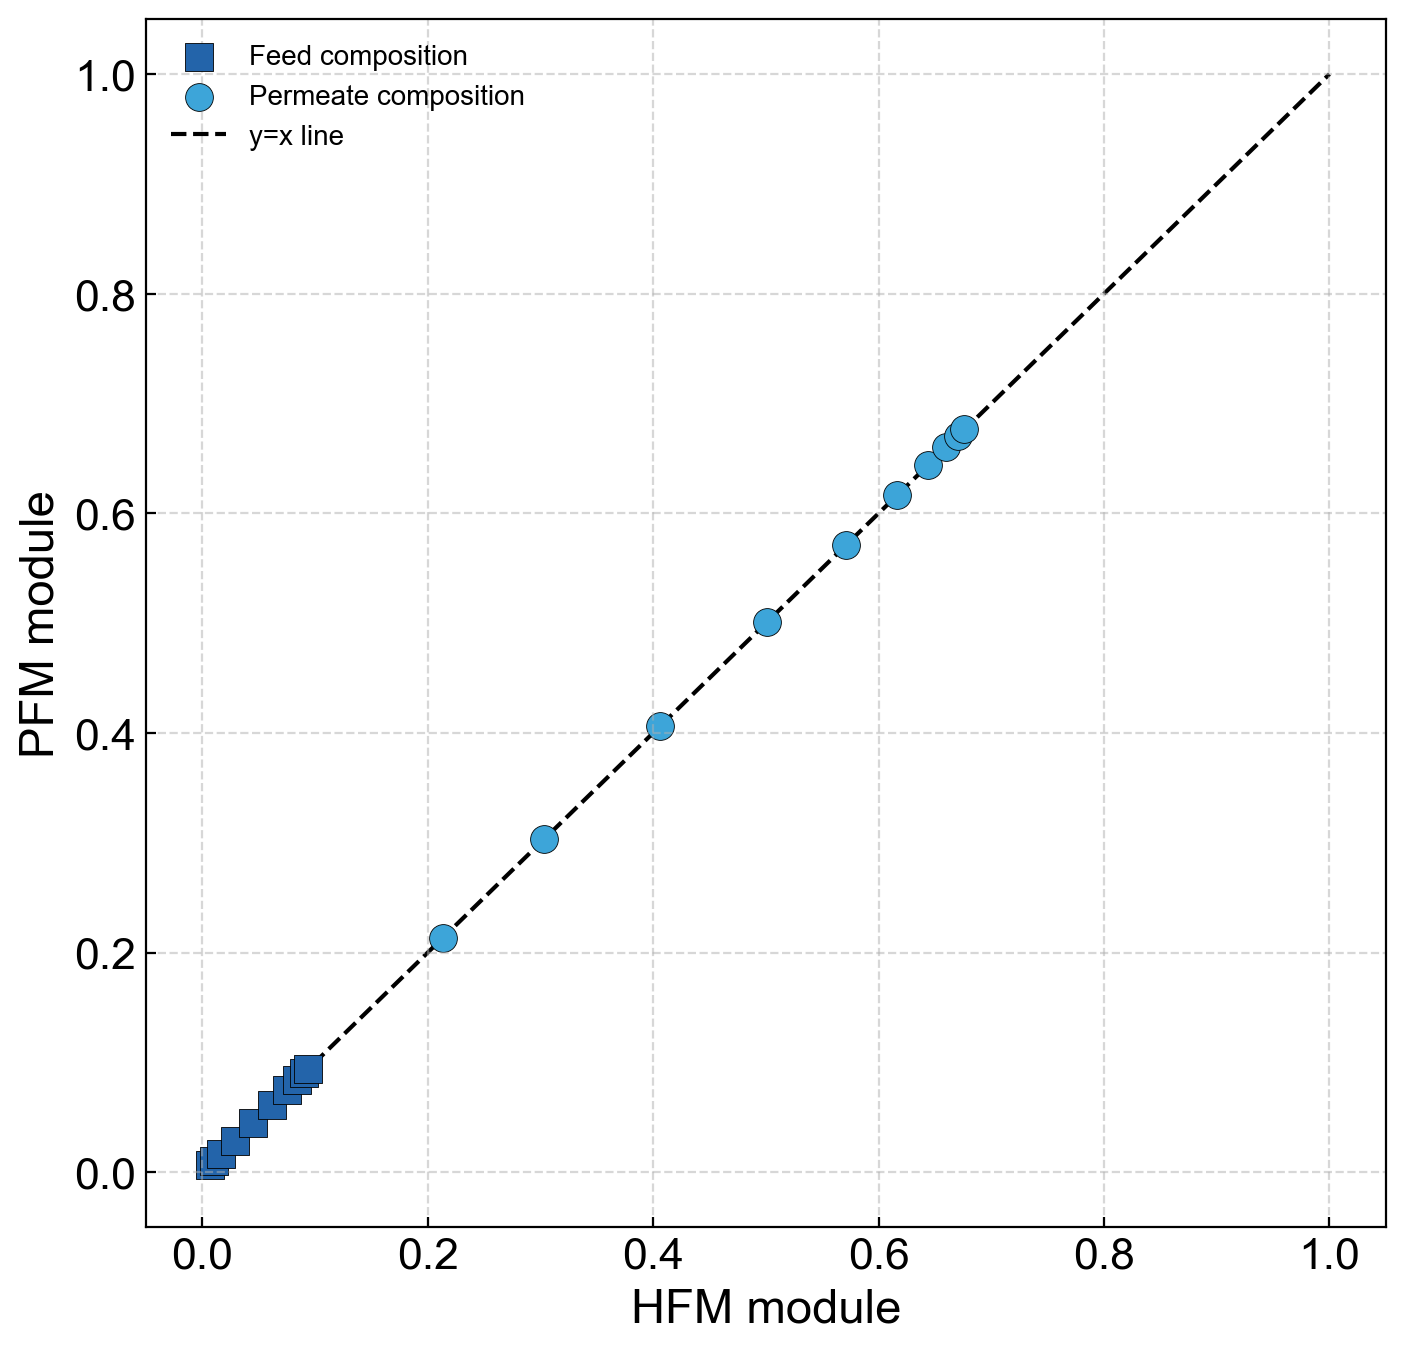

In [52]:
st_arr = np.array(st_res)

# fig, ax = plt.subplots(1,1,figsize=(8,8),dpi=200)

# ax.scatter(st_arr[:,1], 1-st_arr[:,2], label = 'PFM feed purity', c=COLOR_CODE[0], marker = 's', alpha = 0.5)
# ax2 = ax.twinx()
# ax2.scatter(st_arr[:,1], st_arr[:,3], label = 'PFM permeate purity', c=COLOR_CODE[0], alpha = 0.5)

# ax.scatter(st_arr[:,4], 1-st_arr[:,5], label = 'HFM feed purity', c=COLOR_CODE[2], marker = 's', alpha = 0.5)
# ax2.scatter(st_arr[:,4], st_arr[:,6], label = 'HFM permeate purity', c=COLOR_CODE[2], alpha = 0.5)
# ax.grid(False)
# ax2.grid(False)
# plt.show()

plt.figure(figsize=(8,8), dpi=200)
plt.scatter(st_arr[:,5], st_arr[:,2],  label = 'Feed composition', c=COLOR_CODE[0], marker = 's', s = 100, edgecolors='k',
            linewidths=0.3)
plt.scatter(st_arr[:,6], st_arr[:,3], label = 'Permeate composition', c=COLOR_CODE[1], s = 100, edgecolors='k',
            linewidths=0.3)
plt.plot([0, 1], [0, 1], linestyle='--', c='k', label = 'y=x line', zorder=-1)
plt.ylabel('PFM module')
plt.xlabel('HFM module')
plt.legend()
plt.show()

# Rivero et al. - case 1:

In [5]:
A_tot_m2 = 100           # m2
h_channel_um = 250      # um
a_perm_mol_m_pa = np.array([0.4, 20])*3.35e-10     #Permeance(mol/(m2 Pa s))
W_width_m = 1          # m
L_channel_m = 1             # Channel length (m)
N_channel = 100
d_mem_um = 200              # membrane thickness (um)

y_feed = np.array([0.8, 0.2])     # mole fraction (N2, CO2)
P_feed_pa = 405300
P_perm_pa = 40530
T_feed_K = 298.15
dP = np.arange(1500, 40000,2)
N_node = 100

Simulation started
Simulation is completed without warning
Mass balance (error %):  0.0


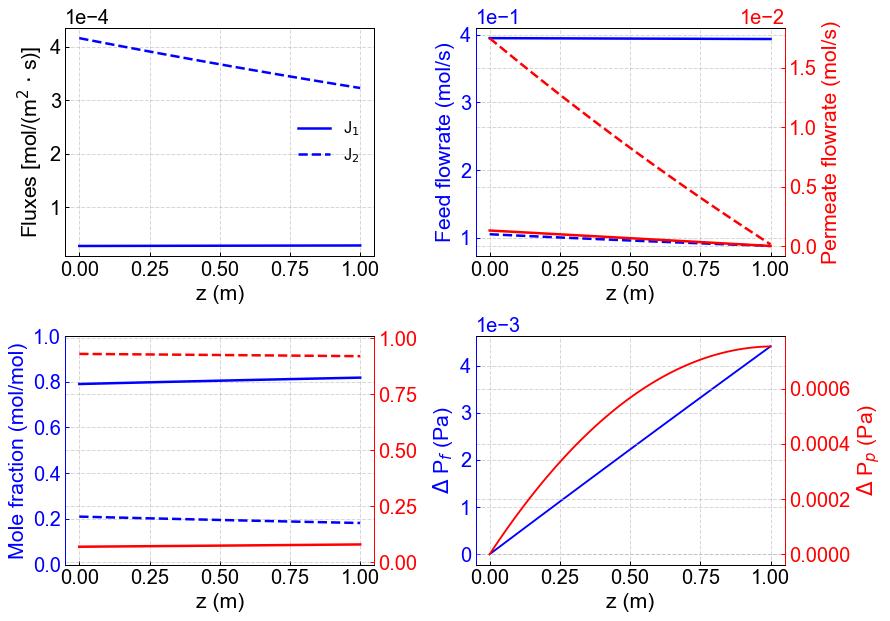

In [18]:
# Operating conditions
P_feed = P_feed_pa*1e-5                # pressure of feed side (bar)
T = T_feed_K
F_feed = 0.5                          # unknown
y_feed = y_feed                        # mole fraction (N2, CO2)
Ff_z0_init = list(y_feed*F_feed)

L_channel = L_channel_m*1e3            # Channel length (mm)
w_channel = W_width_m*1e3              # Channel width (mm)
h_channel = h_channel_um*1e-3          # Channel height (mm)
N_channel = N_channel/2                  # number of channels (-)

# Gas properties
Mw_i = np.array([28e-3, 44e-3])     # Molar weight (kg/mol)

rho_i = np.array([1.17, 1.784])*1e-9     # Density (kg/mm3)
mu_N2 = 17.82e-6
mu_CO2 = 14.94e-6           # CO2 viscosity (Pa s)
# viscosity values from https://www.engineeringtoolbox.com/gases-absolute-dynamic-viscosity-d_1888.html
mu_i = np.array([mu_N2, mu_CO2])*1e-5

k_mass = 1e-1               # Mass transfer coeff. (mm/s)

# Constants
Rgas = 8.314*1e9                # mm3 Pa/K mol

N = N_node
z_dom = np.linspace(0,L_channel,N+1)
a_perm = a_perm_mol_m_pa*1e-6*1e5     #Permeance(mol/(mm2 bar s))

mem_model = PFM(config = 'ct',
                channel_num=N_channel,
                channel_size=[L_channel, w_channel, h_channel],       #mm
                n_component=2,
                n_node=N)

mem_model.membrane_info(thickness=d_mem_um*1e-3,              # mm
                        a_perm=a_perm)
mem_model.gas_prop_info(molar_mass = Mw_i,
                        mu_viscosity = mu_i, 
                        rho_density = rho_i)
mem_model.mass_trans_info(k_mass_transfer = k_mass)
mem_model.boundaryC_info(y_inlet = y_feed,
                            p_f_inlet = P_feed,
                            f_f_inlet = F_feed,
                            T_inlet = T_feed_K,
                            f_sweep = False)
mem_model.initialC_info()
pfm_res = mem_model.run_mem(tolerance=1e-7, 
                    iteration=20000, 
                    Kg=0.01, 
                    cp=False, 
                    cp_cond = False)

mem_model.MassBalance()
mem_model.PlotResults()

# Rivero et al. - case 2:

Simulation started
Simulation is completed without warning


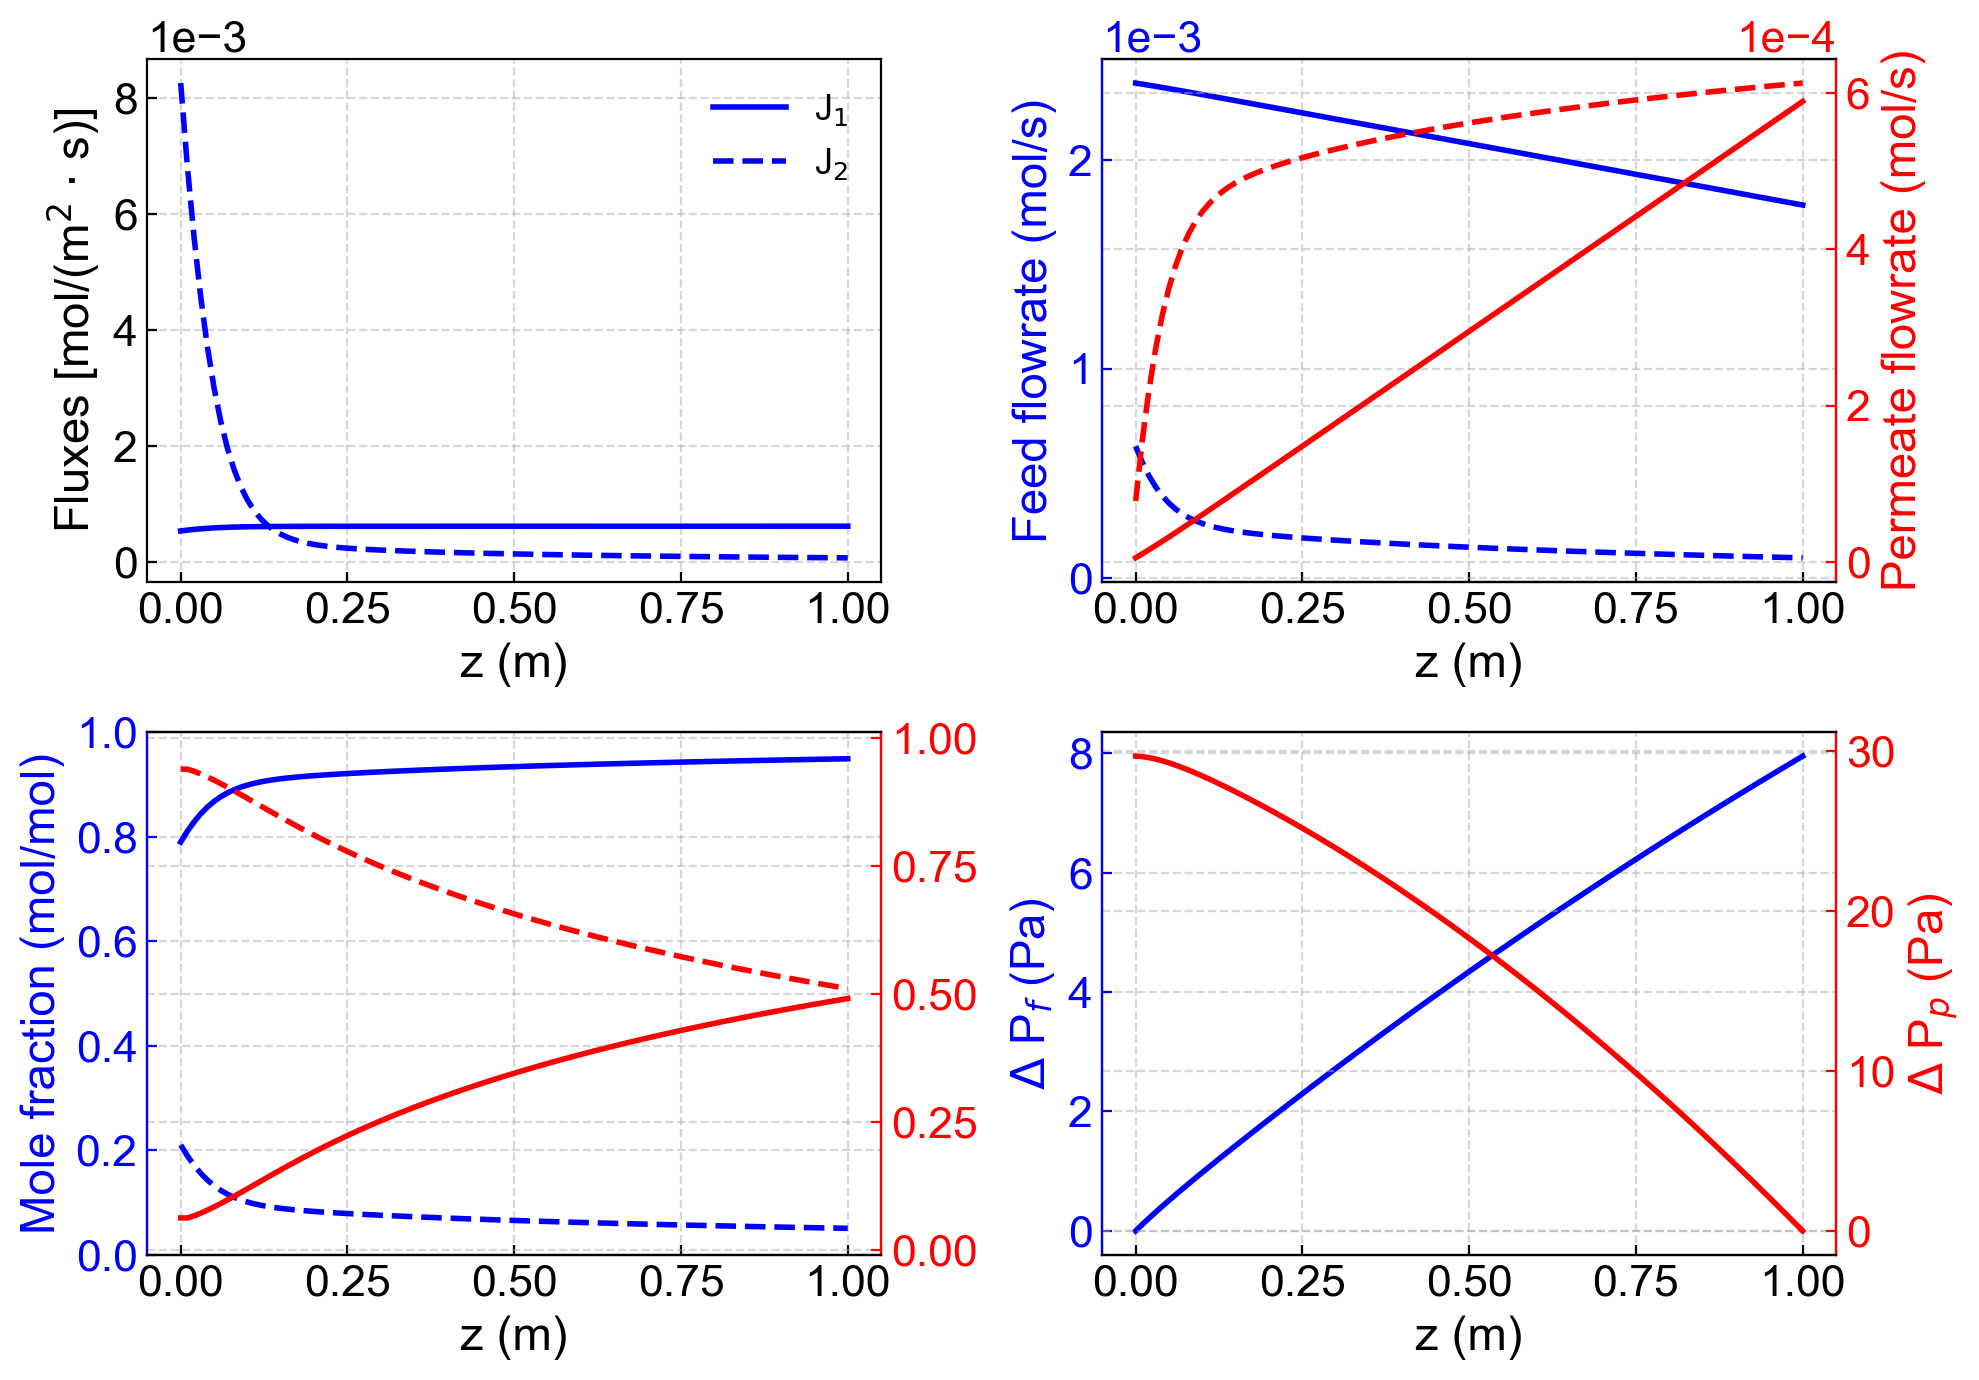

In [27]:
F_feed = 0.003
A_tot_m2 = 94.24           # m2
h_channel_um = 250      # um
a_perm_mol_m_pa = np.array([0.1, 10])*3.35e-10     #Permeance(mol/(m2 Pa s)) --> 오류? (mol/(m2 bar s))
W_width_m = 0.9424          # m
L_channel_m = 1             # Channel length (m)
N_channel = 10
d_mem_um = 200              # membrane thickness (um)

y_feed = np.array([0.79, 0.21])     # mole fraction (N2, O2)
P_feed_pa = 1034000
P_perm_pa = 103400
T_feed_K = 298.15

N_node = 100
# Operating conditions
P_feed = P_feed_pa*1e-5                # pressure of feed side (bar)

y_feed = y_feed                        # mole fraction (N2, O2)

L_channel = L_channel_m*1e3            # Channel length (mm)
w_channel = W_width_m*1e3              # Channel width (mm)
h_channel = h_channel_um*1e-3          # Channel height (mm)
N_channel = N_channel                  # number of channels (-)

# Gas properties
Mw_i = np.array([28e-3, 32e-3])     # Molar weight (kg/mol)

rho_i = np.array([1.17, 1.291])*1e-9     # Density (kg/mm3)
mu_N2 = 17.82e-6
mu_O2 = 20.55e-6           # O2 viscosity (Pa s)
# viscosity values from https://www.engineeringtoolbox.com/gases-absolute-dynamic-viscosity-d_1888.html
mu_i = np.array([mu_N2, mu_O2])   # (Pa s)
k_mass =1e-1
# Constants
Rgas = 8.314*1e9                # mm3 Pa/K mol

N = N_node
a_perm = a_perm_mol_m_pa*1e5*1e-6     #Permeance(mol/(mm2 bar s))

mem_model = PFM(config = 'co',
                channel_num=N_channel,
                channel_size=[L_channel, w_channel, h_channel],       #mm
                n_component=2,
                n_node=N)

mem_model.membrane_info(thickness=d_mem_um*1e-3,              # mm
                        a_perm=a_perm)
mem_model.gas_prop_info(molar_mass = Mw_i,
                        mu_viscosity = mu_i, 
                        rho_density = rho_i)
mem_model.mass_trans_info(k_mass_transfer = k_mass)
mem_model.boundaryC_info(y_inlet = y_feed,
                            p_f_inlet = P_feed,
                            f_f_inlet = F_feed,
                            T_inlet = T_feed_K,
                            f_sweep = False)
mem_model.initialC_info()
y_res = mem_model.run_mem()
mem_model.PlotResults()


In [69]:
N_f = N_channel
N_p = N_f+1
C = 2
_F_f = y_res[:,:C*N_f]
_F_p = y_res[:,C*N_f:C*(N_f+N_p)]
_Pf = y_res[:,C*(N_f+N_p):C*(N_f+N_p)+N_f]
_Pp = y_res[:,C*(N_f+N_p)+N_f:]

F_f_reshaped = _F_f.reshape(-1, N_f, C)         # shape: (time, N_f, C)
Ff_plot = np.sum(F_f_reshaped, axis=-1).T

F_p_reshaped = _F_p.reshape(-1, N_p, C)         # shape: (time, N_f, C)
Fp_plot = np.sum(F_p_reshaped, axis=-1).T


x_1 = (F_f_reshaped/np.sum(F_f_reshaped, axis=-1, keepdims=True))[:,:,0].T
y_1 = (F_p_reshaped/np.sum(F_p_reshaped, axis=-1, keepdims=True))[:,:,1].T

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_102904\2267072514.py:20: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  perm_plot = axes[0].pcolormesh(z, channel_index, F_perm[::-1], shading='auto', cmap='plasma')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_102904\2267072514.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(perm_plot, ax=axes[0], label='Permeate flow [mol/s]')
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_102904\2267072514.py:31: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ret_plot = axes[1].pcolormesh(z, channel_ind

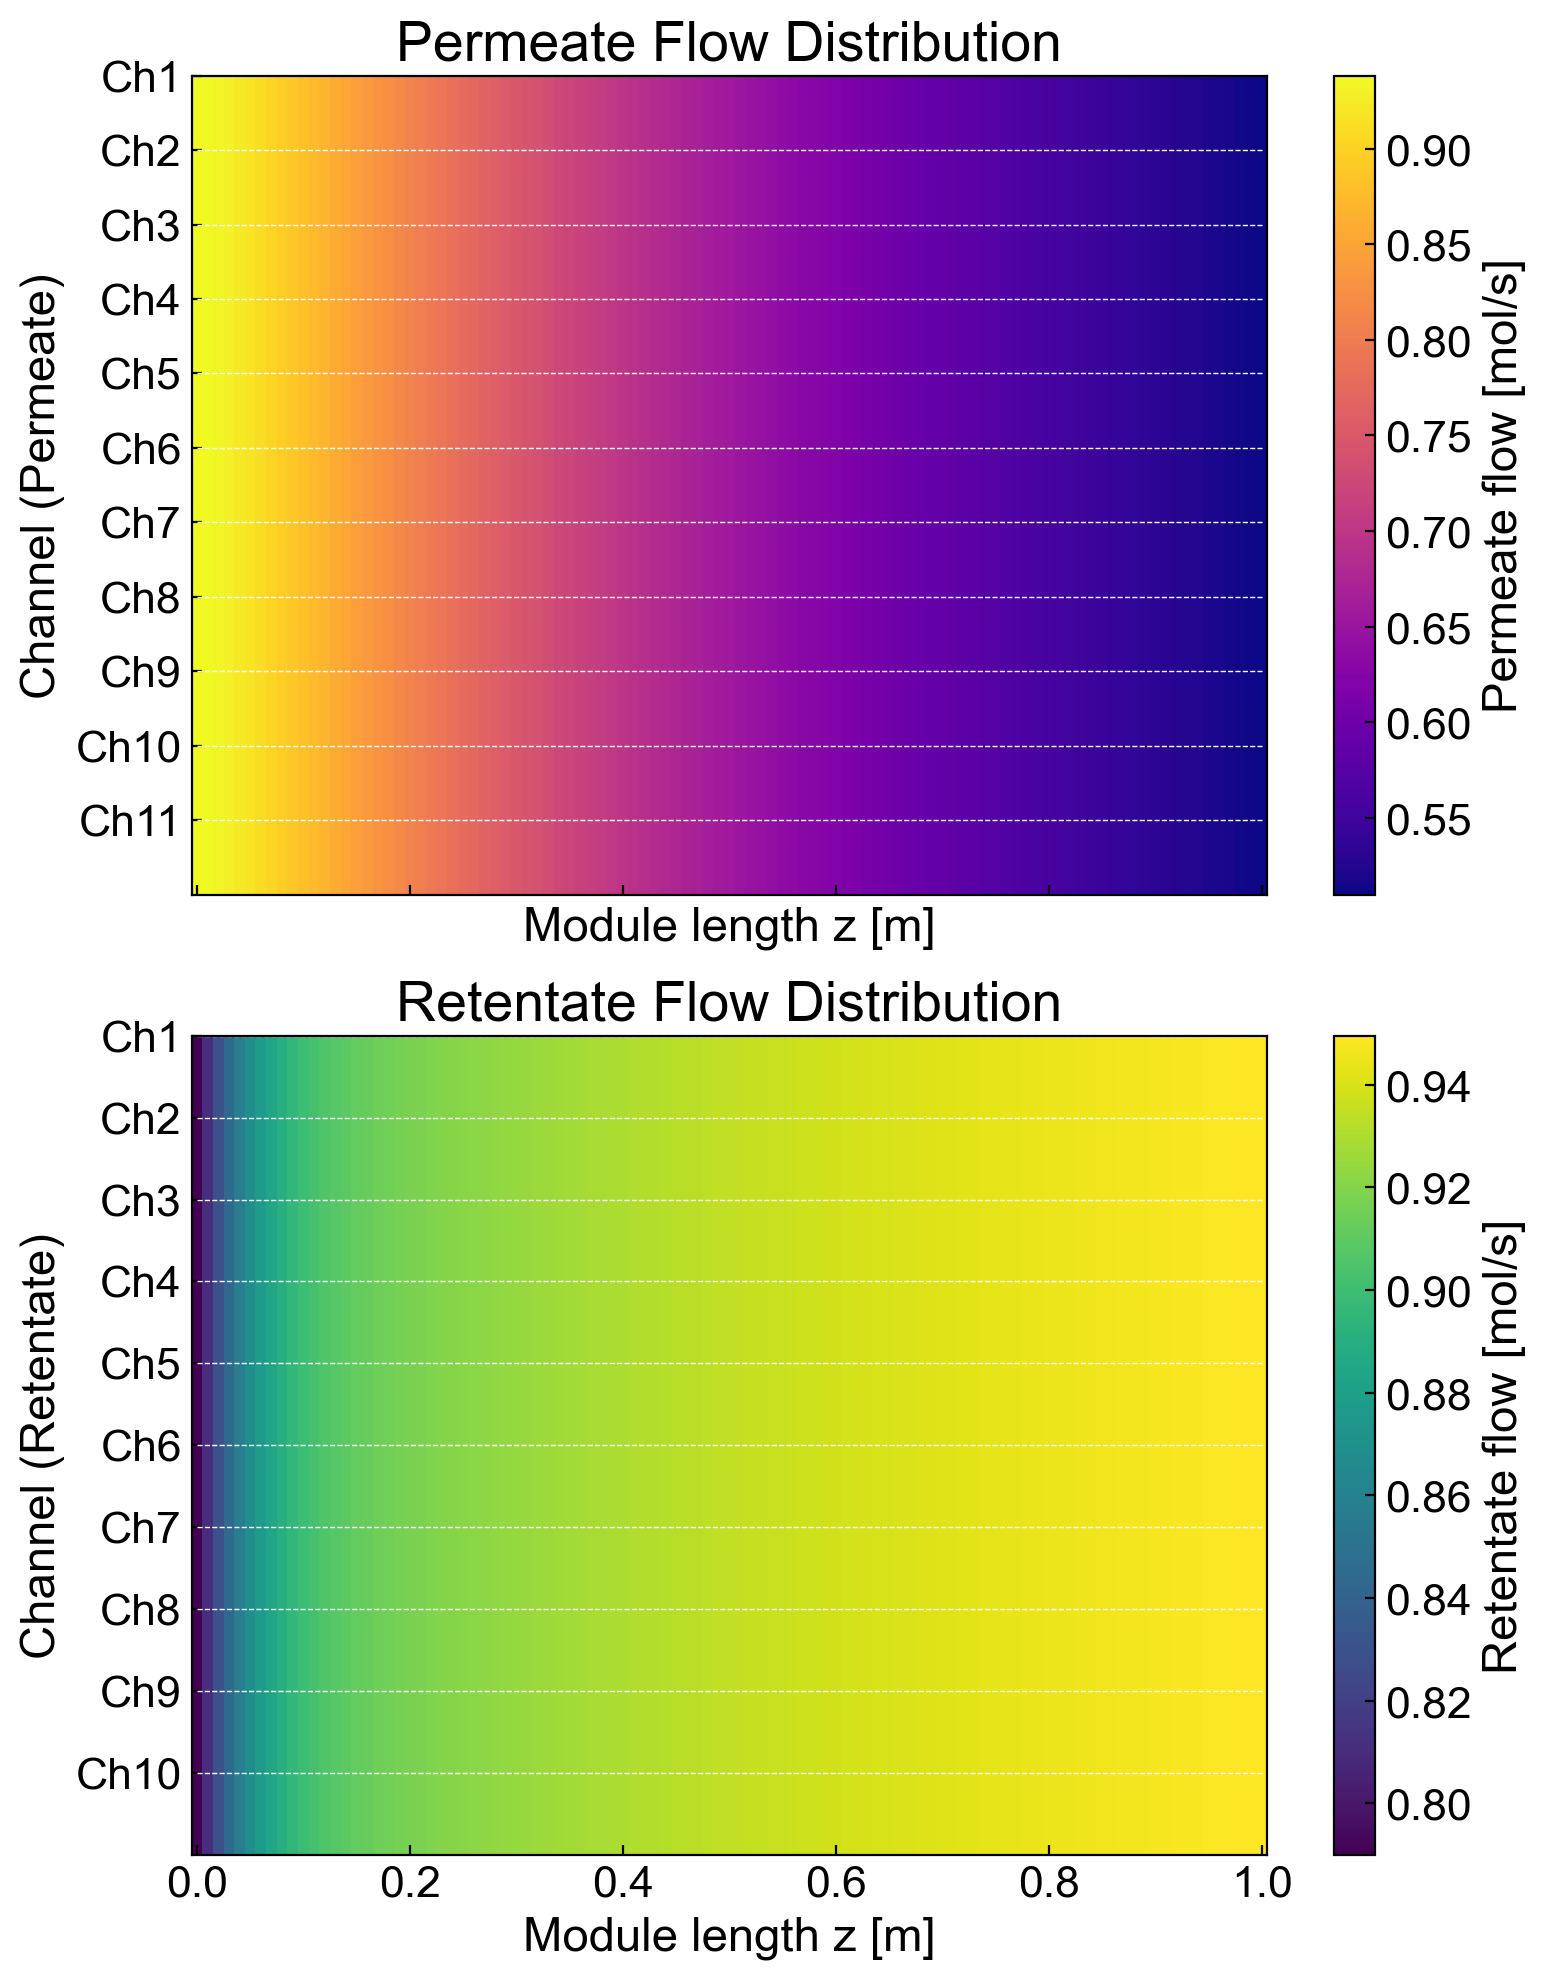

In [75]:
# ====== 기본 변수 세팅 ======
Nz = N + 1  # z 방향 노드 수
Nchannel = N_channel  # 채널 수
z = np.linspace(0, 1, Nz)

# ====== flow 데이터 (사용자 정의) ======
F_perm = y_1  # shape: (Nchannel, Nz)
F_ret = x_1   # shape: (Nchannel, Nz)

# ====== y축: 채널 번호 역순으로 표시 (1~N, 위 → 아래) ======
channel_index = np.arange(Nchannel+1)
channel_labels = [f"Ch{Nchannel - i}" for i in range(Nchannel)]  # 역순으로

# ====== Plot ======
fig, axes = plt.subplots(nrows=2, figsize=(8, 10), sharex=True, dpi=200)

# ===== Permeate =====
channel_index = np.arange(F_perm.shape[0])  # Ny+1

perm_plot = axes[0].pcolormesh(z, channel_index, F_perm[::-1], shading='auto', cmap='plasma')
axes[0].set_yticks(np.arange(F_perm.shape[0]) + 0.5)
axes[0].set_yticklabels([f"Ch{Nchannel+1 - i}" for i in range(Nchannel+1)])

axes[0].set_ylabel('Channel (Permeate)')
axes[0].set_title('Permeate Flow Distribution')
axes[0].set_xlabel('Module length z [m]')
fig.colorbar(perm_plot, ax=axes[0], label='Permeate flow [mol/s]')

# ===== Retentate =====
channel_index = np.arange(F_ret.shape[0])
ret_plot = axes[1].pcolormesh(z, channel_index, F_ret[::-1], shading='auto', cmap='viridis')
axes[1].set_yticks(np.arange(F_ret.shape[0]) + 0.5)
axes[1].set_yticklabels([f"Ch{Nchannel - i}" for i in range(Nchannel)])
axes[1].set_xlabel('Module length z [m]')
axes[1].set_ylabel('Channel (Retentate)')
axes[1].set_title('Retentate Flow Distribution')
fig.colorbar(ret_plot, ax=axes[1], label='Retentate flow [mol/s]')
for y in range(0, Nchannel):
    yline = y + 0.5  # 셀 사이 중앙에 그려지게 보정
    axes[0].hlines(yline, z[0], z[-1], colors='white', linewidth=0.5, linestyles='--')
    axes[1].hlines(yline, z[0], z[-1], colors='white', linewidth=0.5, linestyles='--')

plt.tight_layout()
plt.show()

In [83]:
def PFM_Rivero(F_feed):
    A_tot_m2 = 94.24           # m2
    h_channel_um = 250      # um
    a_perm_mol_m_pa = np.array([0.1, 10])*3.35e-10     #Permeance(mol/(m2 Pa s)) --> 오류? (mol/(m2 bar s))
    W_width_m = 0.9424          # m
    L_channel_m = 1             # Channel length (m)
    N_channel = 50
    d_mem_um = 200              # membrane thickness (um)

    y_feed = np.array([0.79, 0.21])     # mole fraction (N2, O2)
    P_feed_pa = 1034000
    P_perm_pa = 103400
    T_feed_K = 298.15

    N_node = 100
    # Operating conditions
    P_feed = P_feed_pa*1e-5                # pressure of feed side (bar)

    y_feed = y_feed                        # mole fraction (N2, O2)

    L_channel = L_channel_m*1e3            # Channel length (mm)
    w_channel = W_width_m*1e3              # Channel width (mm)
    h_channel = h_channel_um*1e-3          # Channel height (mm)
    N_channel = N_channel                  # number of channels (-)

    # Gas properties
    Mw_i = np.array([28e-3, 32e-3])     # Molar weight (kg/mol)

    rho_i = np.array([1.17, 1.291])*1e-9     # Density (kg/mm3)
    mu_N2 = 17.82e-6
    mu_O2 = 20.55e-6           # O2 viscosity (Pa s)
    # viscosity values from https://www.engineeringtoolbox.com/gases-absolute-dynamic-viscosity-d_1888.html
    mu_i = np.array([mu_N2, mu_O2])   # (Pa s)
    k_mass =1e-1
    # Constants
    Rgas = 8.314*1e9                # mm3 Pa/K mol

    N = N_node
    a_perm = a_perm_mol_m_pa*1e5*1e-6     #Permeance(mol/(mm2 bar s))

    mem_model = PFM(config = 'co',
                    channel_num=N_channel,
                    channel_size=[L_channel, w_channel, h_channel],       #mm
                    n_component=2,
                    n_node=N)

    mem_model.membrane_info(thickness=d_mem_um*1e-3,              # mm
                            a_perm=a_perm)
    mem_model.gas_prop_info(molar_mass = Mw_i,
                            mu_viscosity = mu_i, 
                            rho_density = rho_i)
    mem_model.mass_trans_info(k_mass_transfer = k_mass)
    mem_model.boundaryC_info(y_inlet = y_feed,
                                p_f_inlet = P_feed,
                                f_f_inlet = F_feed,
                                T_inlet = T_feed_K,
                                f_sweep = False)
    mem_model.initialC_info()
    y_res = mem_model.run_mem()
    # mem_model.PlotResults()
    return mem_model, y_res

In [97]:
N_f = 50
N_p = N_f+1
F_dom = np.linspace(0.03, 100, 10)  # Feed flow rate
p_drop_res = []
pfm_res_list = []
for F_feed in F_dom:
    _pfm, _pfm_res = PFM_Rivero(F_feed)

    _Pf = _pfm_res[:,C*(N_f+N_p):C*(N_f+N_p)+N_f]
    Pf = np.mean(_Pf, axis = 1)
    P_drop_pred = Pf[0] - Pf[-1]
    p_drop_res.append(P_drop_pred)
    pfm_res_list.append(_pfm_res)

Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning


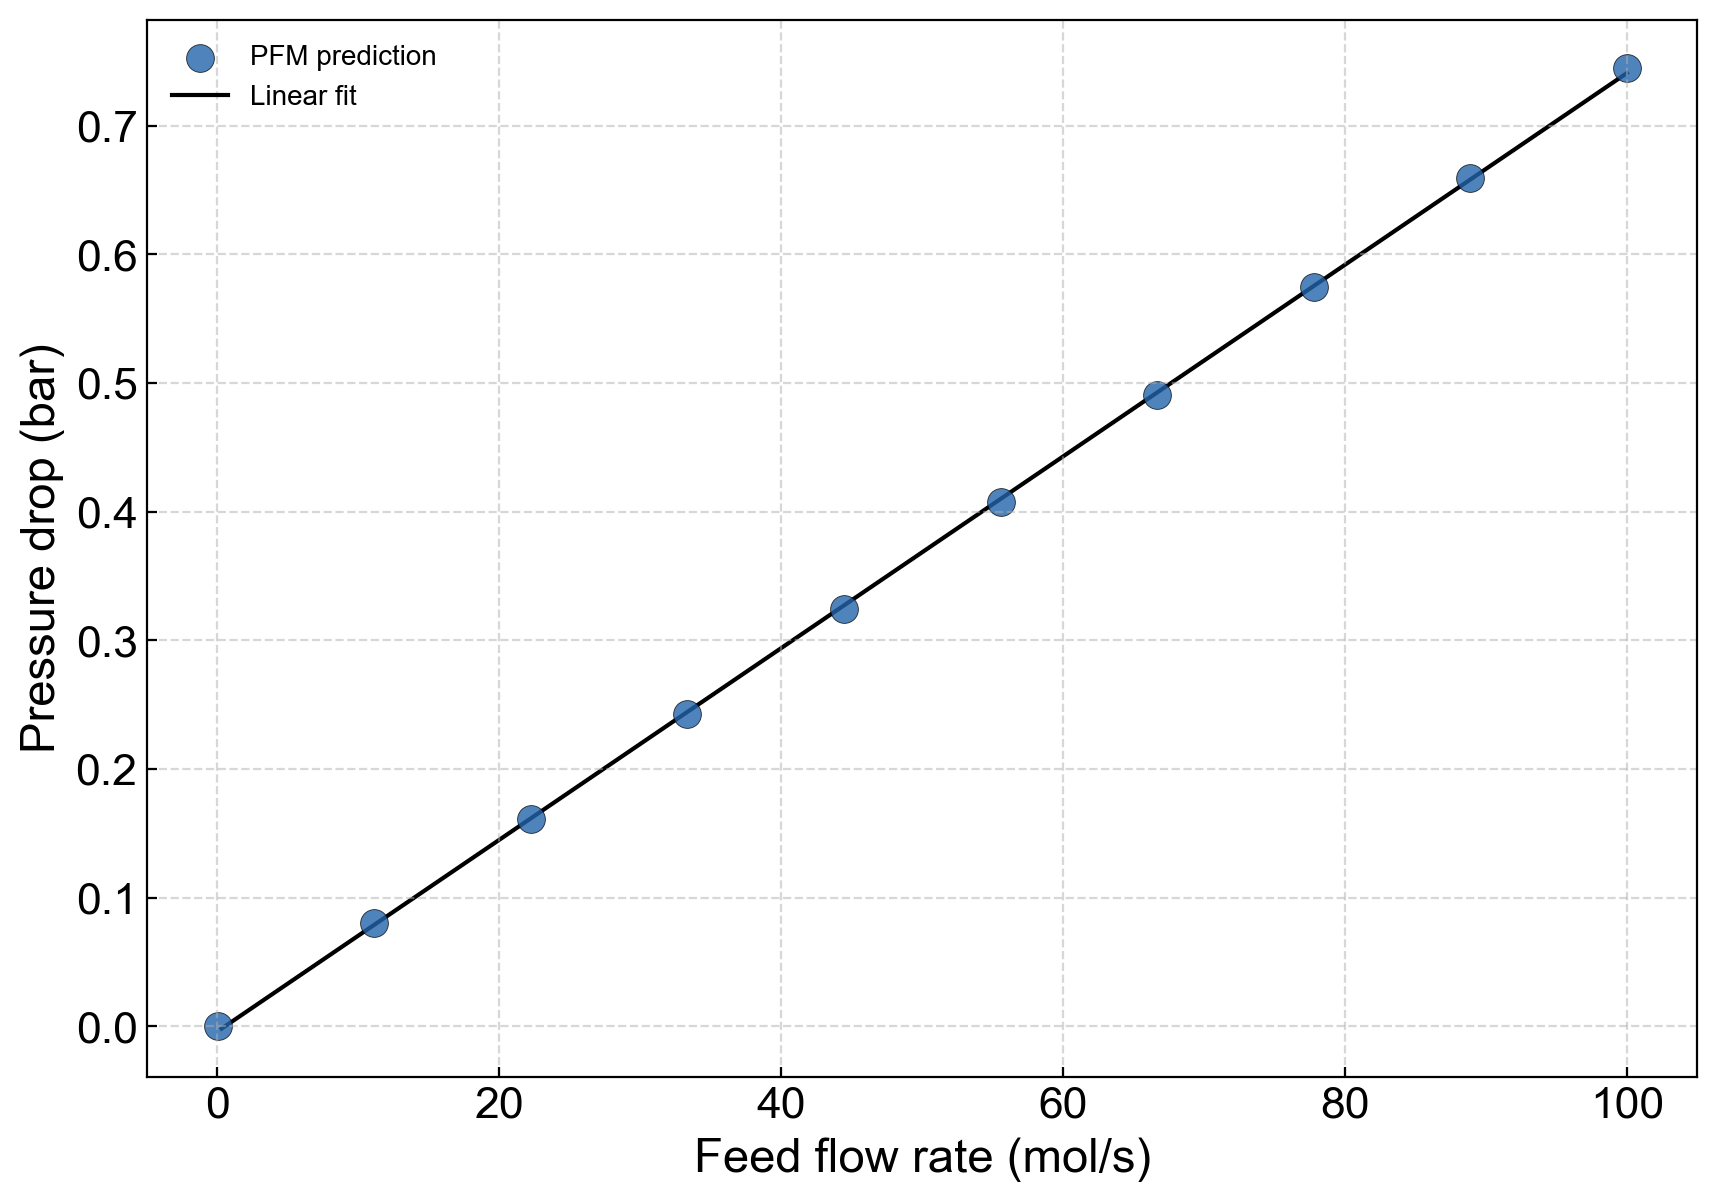

In [100]:
neg_cond = np.array(p_drop_res) >= 0

a = np.polyfit(F_dom[neg_cond], np.array(p_drop_res)[neg_cond], 1)[0]
b = np.polyfit(F_dom[neg_cond], np.array(p_drop_res)[neg_cond], 1)[1]

plt.figure(figsize=(10,7), dpi=200)
plt.scatter(F_dom[neg_cond], np.array(p_drop_res)[neg_cond], c=COLOR_CODE[0], s =100,
            edgecolors='k', linewidths=0.3, label = 'PFM prediction', alpha=0.8)
f_dom = np.logspace(np.log10(0.3), np.log10(100), 100)
plt.plot(f_dom, a*(f_dom) + b, c='k', label = 'Linear fit',zorder = -1)

plt.xlabel('Feed flow rate (mol/s)')
plt.ylabel('Pressure drop (bar)')
plt.legend()
plt.show()

In [102]:
sol_list = []
for P_drop in np.linspace(900, 39000, 20):
    F_feed = (P_drop*1e-5 - b)/a

    _pfm, _pfm_res = PFM_Rivero(F_feed)    
    sol_list.append([P_drop*1e-5, _pfm_res])

Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warning
Simulation started
Simulation is completed without warni

In [132]:
def chan_eval(y_res):
    C = 2
    
    _F_f = y_res[:,:C*N_f]
    _F_p = y_res[:,C*N_f:C*(N_f+N_p)]
    _Pf = y_res[:,C*(N_f+N_p):C*(N_f+N_p)+N_f]
    _Pp = y_res[:,C*(N_f+N_p)+N_f:]
    
    F_f_reshaped = _F_f.reshape(-1, N_f, C)         # shape: (time, N_f, C)
    Ff_plot = np.sum(F_f_reshaped, axis=-1).T       # shape: (Nchannel, Nz)

    F_p_reshaped = _F_p.reshape(-1, N_p, C)         # shape: (time, N_f, C)
    Fp_plot = np.sum(F_p_reshaped, axis=-1).T       # shape: (Nchannel, Nz)
    
    _x_1 = (F_f_reshaped/np.sum(F_f_reshaped, axis=-1, keepdims=True))[:,:,0].T
    _y_1 = (F_p_reshaped/np.sum(F_p_reshaped, axis=-1, keepdims=True))[:,:,1].T  # shape: (Nchannel, Nz)

    Ff = np.sum(Ff_plot, axis=0)    # shape: ( Nz)
    Fp = np.sum(Fp_plot, axis=0)
    
    Ff_end = F_f_reshaped[-1,:,:]
    x_o2 = (np.sum(Ff_end[:,0]))/((np.sum(Ff_end[:,0]))+np.sum(Ff_end[:,1]))
    # print(np.sum(Ff_end[:,0]))
    stg_cut = Fp[-1] / Ff[0]
    recovery = Ff[-1] / Ff[0]
    return stg_cut, recovery, x_o2

In [133]:
val_res = []
for ii in range(len(sol_list)):
    _pfm_res = sol_list[ii][1]
    stg_cut, recovery, x_o2 = chan_eval(_pfm_res)
    val_res.append([stg_cut, recovery, x_o2])

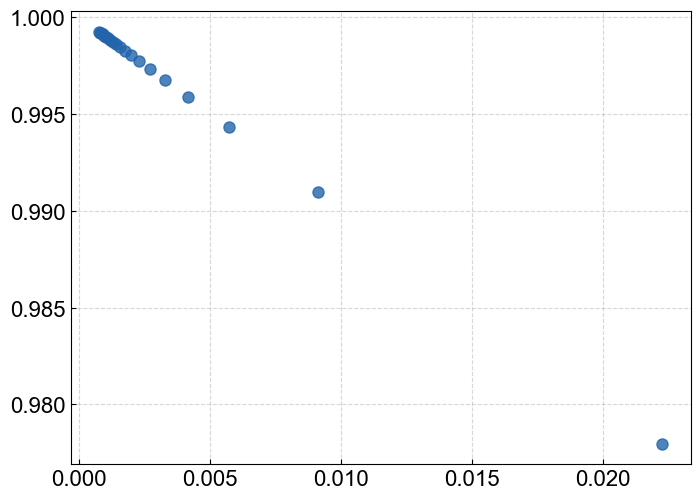

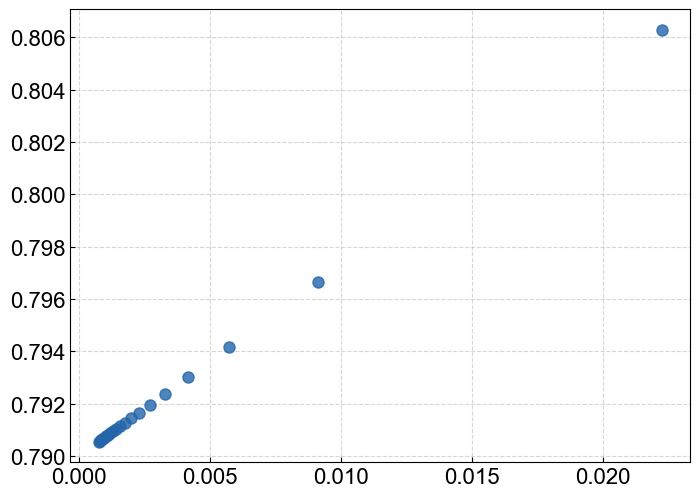

In [134]:
val_arr = np.array(val_res)
plt.figure(figsize=(8,6), dpi=100)
plt.plot(val_arr[:,0], val_arr[:,1], 'o', c=COLOR_CODE[0], label = 'PFM prediction', markersize=8, alpha=0.8)
# plt.xlim([0,0.2])
plt.show()

plt.figure(figsize=(8,6), dpi=100)
plt.plot(val_arr[:,0], val_arr[:,2], 'o', c=COLOR_CODE[0], label = 'PFM prediction', markersize=8, alpha=0.8)
plt.show()

Simulation started
A_chan [mm²]: 23560.0
D_h [mm]: 0.49986739510953165
u_f [mm/s]: 18.010355087467524
rho_f [kg/mm³]: 1.2030147742527886e-08
mu_f [Pa·s]: 1.8393300000000002e-05
Re_f: 0.005888279164922273
fric_f: 10869.049888337762
dPfdz [bar/mm]: -4.242504271002975e-07
A_chan [mm²]: 23560.0
D_h [mm]: 0.49986739510953165
u_f [mm/s]: 17.93000222394136
rho_f [kg/mm³]: 1.2024722956662178e-08
mu_f [Pa·s]: 1.838443223067065e-05
Re_f: 0.005862191623443061
fric_f: 10917.41862276598
dPfdz [bar/mm]: -4.2215401485561663e-07
A_chan [mm²]: 23560.0
D_h [mm]: 0.49986739510953165
u_f [mm/s]: 17.8501191239126
rho_f [kg/mm³]: 1.201928482585809e-08
mu_f [Pa·s]: 1.83755425796613e-05
Re_f: 0.005836256681588946
fric_f: 10965.933044359475
dPfdz [bar/mm]: -4.200699825272078e-07
A_chan [mm²]: 23560.0
D_h [mm]: 0.49986739510953165
u_f [mm/s]: 17.7717403920584
rho_f [kg/mm³]: 1.2013912267872915e-08
mu_f [Pa·s]: 1.836676016982125e-05
Re_f: 0.005810809949594848
fric_f: 11013.955120742217
dPfdz [bar/mm]: -4.1802559

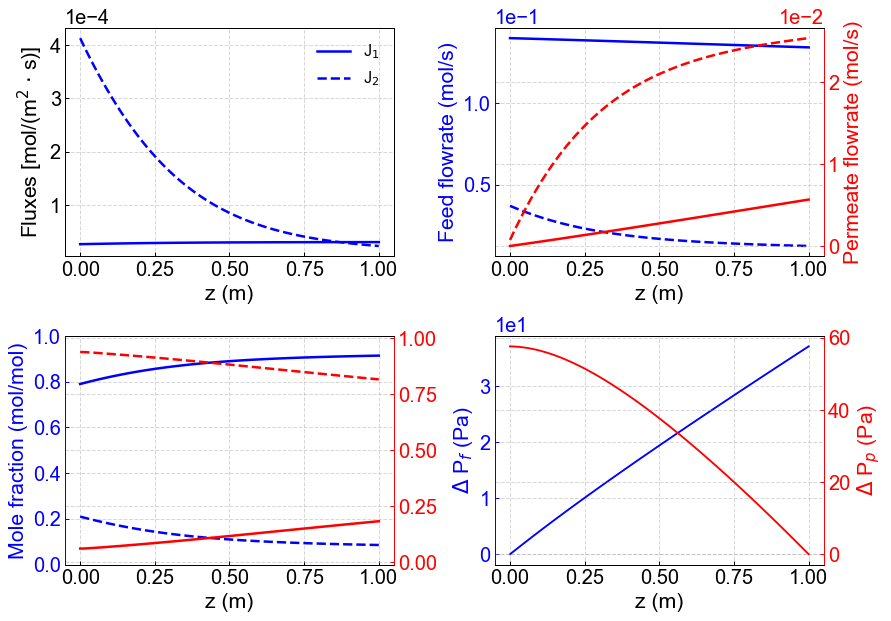

In [6]:
# Operating conditions
P_feed = P_feed_pa*1e-5                # pressure of feed side (bar)
T = T_feed_K
F_feed = 0.177                        # unknown
y_feed = y_feed                        # mole fraction (N2, O2)
Ff_z0_init = list(y_feed*F_feed)

L_channel = L_channel_m*1e3            # Channel length (mm)
w_channel = W_width_m*1e3              # Channel width (mm)
h_channel = h_channel_um*1e-3          # Channel height (mm)
N_channel = N_channel                  # number of channels (-)

# Gas properties
Mw_i = np.array([28e-3, 32e-3])     # Molar weight (kg/mol)

rho_i = np.array([1.17, 1.291])*1e-9     # Density (kg/mm3)
mu_N2 = 17.82e-6
mu_O2 = 20.55e-6           # O2 viscosity (Pa s)
# viscosity values from https://www.engineeringtoolbox.com/gases-absolute-dynamic-viscosity-d_1888.html
mu_i = np.array([mu_N2, mu_O2])   # (Pa s)
k_mass =1e-1
# Constants
Rgas = 8.314*1e9                # mm3 Pa/K mol

N = N_node
z_dom = np.linspace(0,L_channel,N+1)
a_perm = a_perm_mol_m_pa*1e5*1e-6     #Permeance(mol/(mm2 bar s))

mem_model = PFM(config = 'co',
                channel_num=N_channel,
                channel_size=[L_channel, w_channel, h_channel],       #mm
                n_component=2,
                n_node=N)

mem_model.membrane_info(thickness=d_mem_um*1e-3,              # mm
                        a_perm=a_perm)
mem_model.gas_prop_info(molar_mass = Mw_i,
                        mu_viscosity = mu_i, 
                        rho_density = rho_i)
mem_model.mass_trans_info(k_mass_transfer = k_mass)
mem_model.boundaryC_info(y_inlet = y_feed,
                            p_f_inlet = P_feed,
                            f_f_inlet = F_feed,
                            T_inlet = T_feed_K,
                            f_sweep = False)
mem_model.initialC_info()
pfm_res = mem_model.run_mem(tolerance=1e-7, 
                    iteration=10000, 
                    Kg=0.01, 
                    cp=False, 
                    cp_cond = False)

mem_model.MassBalance()
mem_model.PlotResults()

# sdkf

Simulation started


c:\Users\PSID_PC22\Documents\GitHub\pySembrane\Usage & examples\simulator.py:549: RuntimeWarning: invalid value encountered in double_scalars
  err = [(ffp-_factor*(J[ii,0]))/ffp for ii, ffp in enumerate(fp_0_i)]


Simulation is completed without warning
Mass balance (error %):  nan


IndexError: list index out of range

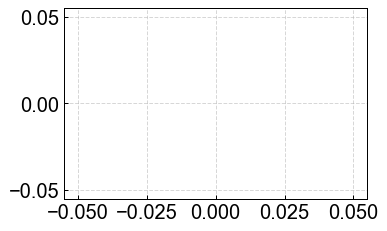

In [71]:
# Operating conditions
P_feed = 106.7e3*1e-5                # pressure of feed side (bar)
T = 323
F_feed = 10           # volume flow rate (m3/s)
y_feed = np.array([0.395, 0.089, 0.516])     # mole fraction (CH4, ethane, carrier gas)
Ff_z0_init = list(y_feed*F_feed)

n_stg = 1
mode = 'P2F'

# Sizing parameters
thickness = 15e-6*1e3
D_inner = 200*1e-3            # Membrane inner diameter (mm)
D_outer = D_inner+2*thickness            # Membrane outer diameter (mm)

D_module = 0.1*1e3            # Module diameter (mm)
L = 0.8*1e3    
N_fiber = 0.3*1e6/(np.pi * D_outer*L)               # number of fiber (-)
               # fiber length (mm)
Ac_shell = np.pi*D_module**2/4 - N_fiber*np.pi*D_outer**2/4     # (mm^2)
config = 'COFS'

# Gas properties
Mw_i = np.array([16e-3, 30e-3, 2e-3])     # Molar weight (kg/mol)
rho_i = np.array([0.598, 1.123,0.1488])*1e-9     # Density (kg/mm3)
mu_CH4 = 11.86e-6           # CO2 viscosity (Pa s)
mu_C2H6 = 10.08e-6           # CH4 viscosity (Pa s)
mu_He = 2.1e-5
# viscosity values from https://www.engineeringtoolbox.com/gases-absolute-dynamic-viscosity-d_1888.html
mu_i = np.array([mu_CH4, mu_C2H6, mu_He])

k_mass = 1e-1               # Mass transfer coeff. (mm/s)

# Constants
Rgas = 8.314*1e9                # mm3 Pa/K mol

N = 400
z_dom = np.linspace(0,L,N+1)
a_perm = np.array([2.238e-10, 2.238/3*1e-10, 0])*1e-6*1e5     #Permeance(m3/(m2 Pa s)) * density (mol/m3)

n_component = 3
mem = MembraneProc(config, L, D_module, N_fiber, 
            n_component, n_node = N)
mem.membrane_info(a_perm, D_inner, D_outer)
mem.gas_prop_info(Mw_i, mu_i, rho_i)
mem.mass_trans_info(k_mass)
mem.boundaryC_info(y_feed, P_feed, F_feed, T)
mem.initialC_info()

#single
hfm_res = mem.run_mem(cp=False, cp_cond = [1, 298])
err = mem.MassBalance()

mem.PlotResults(component=['{CO_2}', '{CH_4}'])